In [15]:
%matplotlib inline

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import cv2
import time
import pandas as pd 


### Load train and test images into np arrays

In [2]:
start_time = time.time()

# appending all labels from data set
labels_total = []
img_dir=glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Training/*')
labels_total={d:i for i,d in enumerate(np.unique([label.split("/")[-1] for label in img_dir]))}

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007844686508178711 seconds ---


In [3]:
start_time = time.time()

# upload train data from local folder and separte them into two arrays(images, labels)
images_train = []
labels_train = []
img_dir=glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Training/*')

for label in img_dir:
    fruit_label = label.split("/")[-1]
    
    for img_dir in glob.glob(os.path.join(label, "*.jpg")):
        labels_train.append(labels_total[fruit_label])
        image = cv2.imread(img_dir)
        image = cv2.resize(image, (45,45))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images_train.append(image.flatten())

images_train = np.array(images_train)
labels_train = np.array(labels_train)

print("the number of test images : {}".format(labels_train.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

the number of test images : 28736
--- 21.74592423439026 seconds ---


In [8]:
images_train.shape

(28736, 6075)

In [4]:
start_time = time.time()

# upload test data from local folder and separte them into two arrays(images, labels)
images_test = []
labels_test = []
img_dir2 = glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Validation/*')

for label in img_dir2:
    fruit_label = label.split("/")[-1]
    
    for img_dir2 in glob.glob(os.path.join(label, "*.jpg")):
        labels_test.append(labels_total[fruit_label])
        image = cv2.imread(img_dir2)
        image = cv2.resize(image, (45,45))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images_test.append(image.flatten())

images_test = np.array(images_test)
labels_test = np.array(labels_test)

print("the number of train images : {}".format(labels_test.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

the number of train images : 9673
--- 7.272659778594971 seconds ---


### Run decision trees in multiple depth to find out the highest accuracy score

In [9]:
start_time = time.time()

# calculate accuracy score using different number of depth in Decision Tree
tree_accuracy= []
for i in range(30,50,5):
    tree = DecisionTreeClassifier(max_depth=i)
    tree_fit = tree.fit(images_train, labels_train)
    pred = tree.predict(images_test)
    tree_accuracy.append(accuracy_score(labels_test, pred))

print("--- %s seconds ---" % (time.time() - start_time))

--- 416.7486340999603 seconds ---


the highest accuracy score for Decision tree : 0.7885867879665047


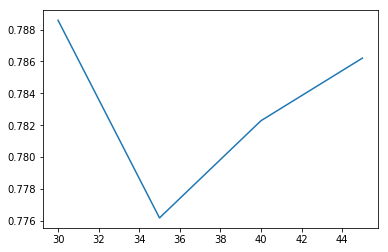

In [28]:
plt.plot(range(30,50,5), tree_accuracy)

print("the highest accuracy score for Decision tree : {}".format(max(tree_accuracy)))

depth = 30 gives the highest accuracy score

##### Run Decision tree with optimal model and fit test images for accuracy score

In [30]:
start_time = time.time()

tree_opt = DecisionTreeClassifier(max_depth=30)
tree_opt_fit = tree_opt.fit(images_train, labels_train)
tree_prediction = tree_opt.predict(images_test)
tree_opt_accuracy = accuracy_score(labels_test,tree_prediction)

print("Decision Tree accuracy score : {:.4f}".format(tree_opt_accuracy))
print("--- %s seconds ---" % (time.time() - start_time))


Decision Tree accuracy score : 0.7812
--- 103.20194101333618 seconds ---


### Run Random Forest with different numbers of estimators to find the highest accuracy score

In [17]:
start_time = time.time()

# create RandomForest classifier
test_accuracy_random = {}

for i in range(10,200, 10):
    forest = RandomForestClassifier(n_estimators=i, n_jobs=4, )
    forest.fit(images_train, labels_train)
    test_predict = forest.predict(images_test)
    test_accuracy_random[i]=accuracy_score(labels_test, test_predict)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 518.1488790512085 seconds ---


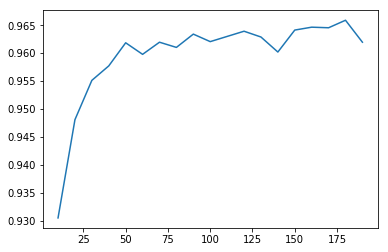

In [18]:
plt.plot(test_accuracy_random.keys(), test_accuracy_random.values())

In [27]:
max_rf = max(test_accuracy_random.values())
print("the highest accuracy score : {} ".format(max_rf))
print("the number of estimators : 180")

the highest accuracy score : 0.9658844205520521 
the number of estimators : 180


### Run PCA and use SVM to classify

In [5]:
start_time = time.time()

# create PCA classifier
pca_clf = PCA(n_components = 150)
pca_train = pca_clf.fit(images_train)


print("--- %s seconds ---" % (time.time() - start_time))

--- 13.667150020599365 seconds ---


In [6]:
total_variance_train = sum(pca_train.explained_variance_ratio_)

print("Total variance explained by 150 features : {:.2f}".format(total_variance_train))

Total variance explained by 150 features : 0.95


In [7]:
# transform original data with 6075 dimensions into 150 dimensions
pca_train_transform = pca_train.transform(images_train)
print("original dimension : {}".format(images_train.shape))
print("transformed dimension : {}".format(pca_train_transform.shape))

original dimension : (28736, 6075)
transformed dimension : (28736, 150)


In [ ]:
start_time = time.time()

# run SVM using reduced dataset and rbf kernel function
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
svm_clf_2 = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_train_2 = svm_clf_2.fit(pca_train_transform, labels_train)

print("--- %s seconds ---" % (time.time() - start_time))

In [8]:
start_time = time.time()

# run SVM using reduced dataset and rbf kernel function
svm_clf = svm.SVC(kernel='rbf')
svm_train = svm_clf.fit(pca_train_transform, labels_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 249.9545440673828 seconds ---


In [9]:
start_time = time.time()

# transform test images using PCA
pca_test_transform = pca_train.transform(images_test)

# predict using svm and reduced test images
svm_pred = svm_train.predict(pca_test_transform)

print("--- %s seconds ---" % (time.time() - start_time))

--- 63.346153020858765 seconds ---


In [11]:
svm_accuracy = accuracy_score(labels_test, svm_pred)

print("svm accuracy score : {}".format(svm_accuracy))

svm accuracy score : 0.0210896309314587
